In [1]:
import numpy as np 
import scanpy as sc
import torch 

import matplotlib.pyplot as plt 

from importlib import reload 
import os 
from pprint import pprint

import utils

# data

In [2]:
import data

scanpy==1.8.2 anndata==0.8.0 umap==0.5.2 numpy==1.21.5 scipy==1.8.0 pandas==1.3.5 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9 pynndescent==0.5.6


In [3]:
# adata = data.preprocess_pbmc3k(data.get_pbmc3k())
adata = data.preprocess_paul15(data.get_paul15())

target_col_categories = 'paul15_clusters'
target_col = 'paul15_clusters_ind'
adata

/home/hbl/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/usr/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/data.py:132: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['paul15_clusters_ind'] = adata.obs.paul15_clusters.replace(cats.to_list(), range(len(cats)))


AnnData object with n_obs × n_vars = 2730 × 685
    obs: 'paul15_clusters', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'paul15_clusters_ind'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'iroot', 'log1p', 'hvg'

# svm

In [4]:
import svm

In [5]:
n_train = 1800 

x_train, x_test, y_train, y_test = svm.split_data_cellclass(adata, n_train, target_col=target_col)
clf = svm.svm_cellclass(x_train, y_train, x_test, y_test, kernel='linear')

SVM test accuracy: 60.0


# mlp

In [6]:
import mlp

In [7]:
NUM_EPOCHS = 1000
LR = 0.001 
n_train = 1800

x = torch.tensor(adata.X)
y = data.target2onehot(adata, target_col=target_col)

input_dim = x.shape[1]
output_dim = data.num_categories(adata, target_col=target_col_categories)
hidden_dim = 64

accuracy: tensor(50.)


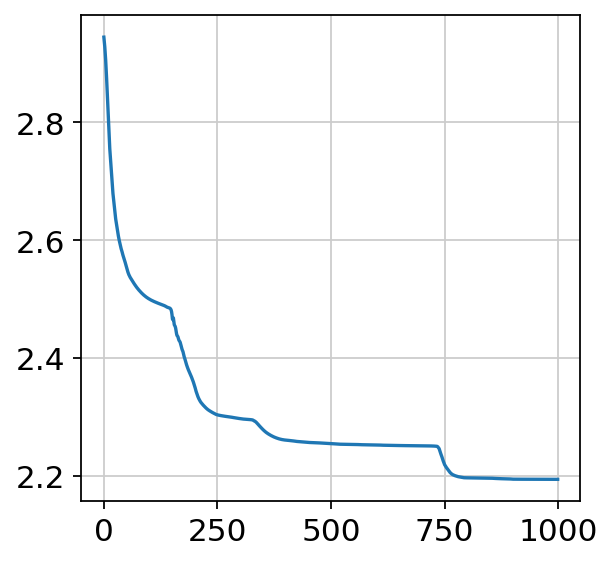

In [8]:
x_train, y_train = x[:n_train], y[:n_train]
x_test, y_test = x[n_train:], y[n_train:]

model = mlp.SimpleMLP(input_dim, output_dim, hidden_dim)

losses = mlp.train(model, x_train, y_train, lr=LR, num_epochs=NUM_EPOCHS)
plt.plot(losses)
test_acc = mlp.eval(model, x_test, y_test)

# gcn - REDUNDANT

In [9]:
import gcn

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:04)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
[EPOCH 0] train loss: 2.944439172744751
[EPOCH 100] train loss: 2.9195897579193115
[EPOCH 200] train loss: 2.917479991912842
[EPOCH 300] train loss: 2.9168224334716797
[EPOCH 400] train loss: 2.9164443016052246
[EPOCH 500] train loss: 2.9161782264709473
[EPOCH 600] train loss: 2.9159576892852783
[EPOCH 700] train loss: 2.9156575202941895
[EPOCH 800] train loss: 2.912612199783325
[EPOCH 900] train loss: 2.9118852615356445
[EPOCH 1000] train loss: 2.9106621742248535
accuracy: 36.774192810058594


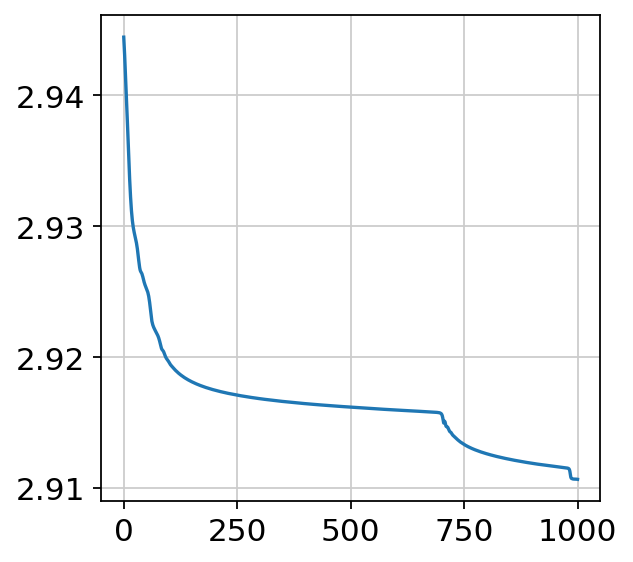

In [12]:
NUM_EPOCHS = 1001
LR = 0.001 
n_train = 1800

x = torch.tensor(adata.X)
y = data.target2onehot(adata, target_col=target_col)

# use static k-nn adjacency 
adata = data.preprocess_leiden(adata)
A = data.connectivities2adjacency(adata)

input_dim = x.shape[1]
output_dim = data.num_categories(adata, target_col=target_col_categories)

model = gcn.SimpleGNN(input_dim, output_dim, A, k=1)

losses = gcn.train(model, x, y, n_train, lr=LR, num_epochs=NUM_EPOCHS)
plt.plot(losses)
test_acc = gcn.eval(model, x, y, n_train)

[EPOCH 0] train loss: 2.944676160812378
[EPOCH 100] train loss: 2.9370007514953613
[EPOCH 200] train loss: 2.9370007514953613
[EPOCH 300] train loss: 2.9370007514953613
[EPOCH 400] train loss: 2.9370007514953613
[EPOCH 500] train loss: 2.937000274658203
[EPOCH 600] train loss: 2.9370005130767822
[EPOCH 700] train loss: 2.9370005130767822
[EPOCH 800] train loss: 2.9370005130767822
[EPOCH 900] train loss: 2.937000274658203
[EPOCH 1000] train loss: 2.937000274658203
accuracy: 12.150537490844727


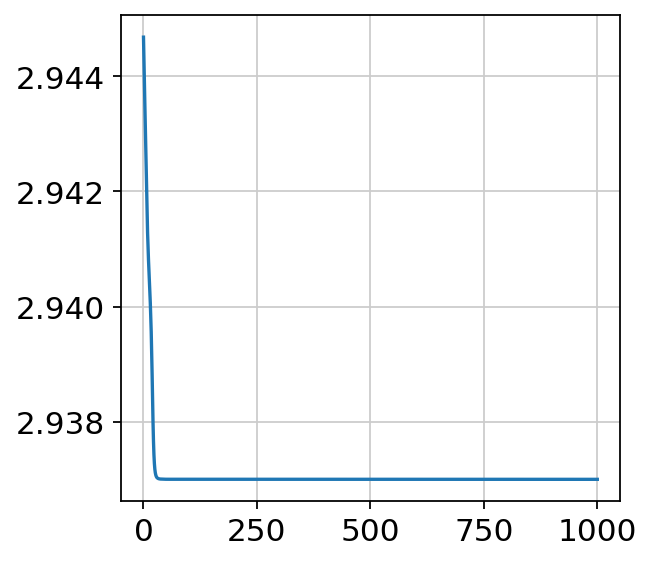

In [13]:
# try fully connected adjacency 
A = torch.ones_like(A)

model = gcn.SimpleGNN(input_dim, output_dim, A, k=1)

losses = gcn.train(model, x, y, n_train, lr=LR, num_epochs=NUM_EPOCHS)
plt.plot(losses)
test_acc = gcn.eval(model, x, y, n_train)

[EPOCH 0] train loss: 2.944340229034424
[EPOCH 100] train loss: 2.9130940437316895
[EPOCH 200] train loss: 2.906358003616333
[EPOCH 300] train loss: 2.8926398754119873
[EPOCH 400] train loss: 2.889456033706665
[EPOCH 500] train loss: 2.8879504203796387
[EPOCH 600] train loss: 2.887082576751709
[EPOCH 700] train loss: 2.885408878326416
[EPOCH 800] train loss: 2.8847389221191406
[EPOCH 900] train loss: 2.884276866912842
[EPOCH 1000] train loss: 2.8840255737304688
accuracy: 44.94623565673828


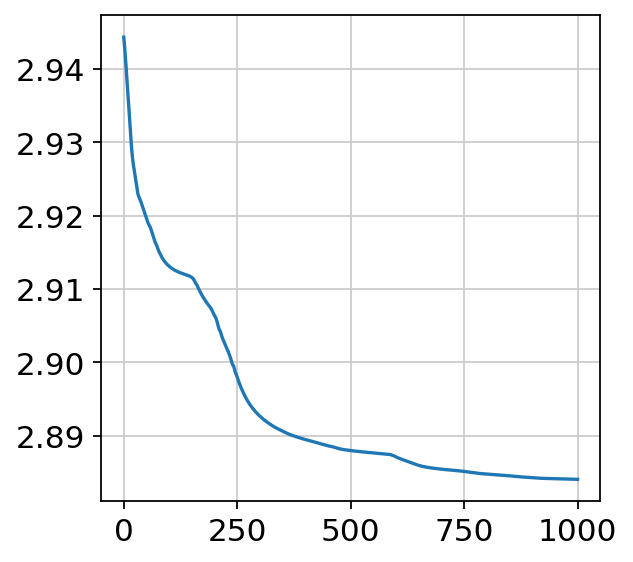

In [15]:
# try empty connected adjacency 
A = torch.zeros_like(A)

model = gcn.SimpleGNN(input_dim, output_dim, A, k=1)

losses = gcn.train(model, x, y, n_train, lr=LR, num_epochs=NUM_EPOCHS)
plt.plot(losses)
test_acc = gcn.eval(model, x, y, n_train)

# generic gnn 

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = torch.tensor(adata.X)
y = data.target2onehot(adata, target_col=target_col)

x = x.to(device) 
y = y.to(device)

In [7]:
import torch_cluster

adata = data.preprocess_leiden(adata)
edge_index_pp = data.connectivities2edge_index(adata)  
edge_index_full = torch.ones((2, x.shape[0]*2), dtype=torch.long)  
edge_index_empty = torch.empty(2, 0, dtype=torch.long) 
edge_index_implied = data.implied_edge_index(adata, threshold_quantile=0.75)
edge_index_knn = torch_cluster.knn(x, x, 50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)
Distance threshold 0.75 quantile: 30.36
Adjacency sparisty: 0.2546


In [45]:
import gnn
import torch_geometric as pyg

In [79]:
reload(gnn)

<module 'gnn' from '/mnt/c/Users/han13/OneDrive/Documents/MPhil ACS/L45 Representation Learning on Graphs and Networks/project/code/gnn.py'>

model params: 13414
[EPOCH 0] train loss: 3.2760016918182373
[EPOCH 100] train loss: 0.976061224937439
[EPOCH 200] train loss: 0.7150325775146484
[EPOCH 300] train loss: 0.5705362558364868
[EPOCH 400] train loss: 0.4521597623825073
[EPOCH 500] train loss: 0.3519429564476013
[EPOCH 600] train loss: 0.2698022425174713
[EPOCH 700] train loss: 0.2039290815591812
[EPOCH 800] train loss: 0.15244078636169434
[EPOCH 900] train loss: 0.1137029230594635
[EPOCH 1000] train loss: 0.0853673666715622
accuracy: 57.63440704345703


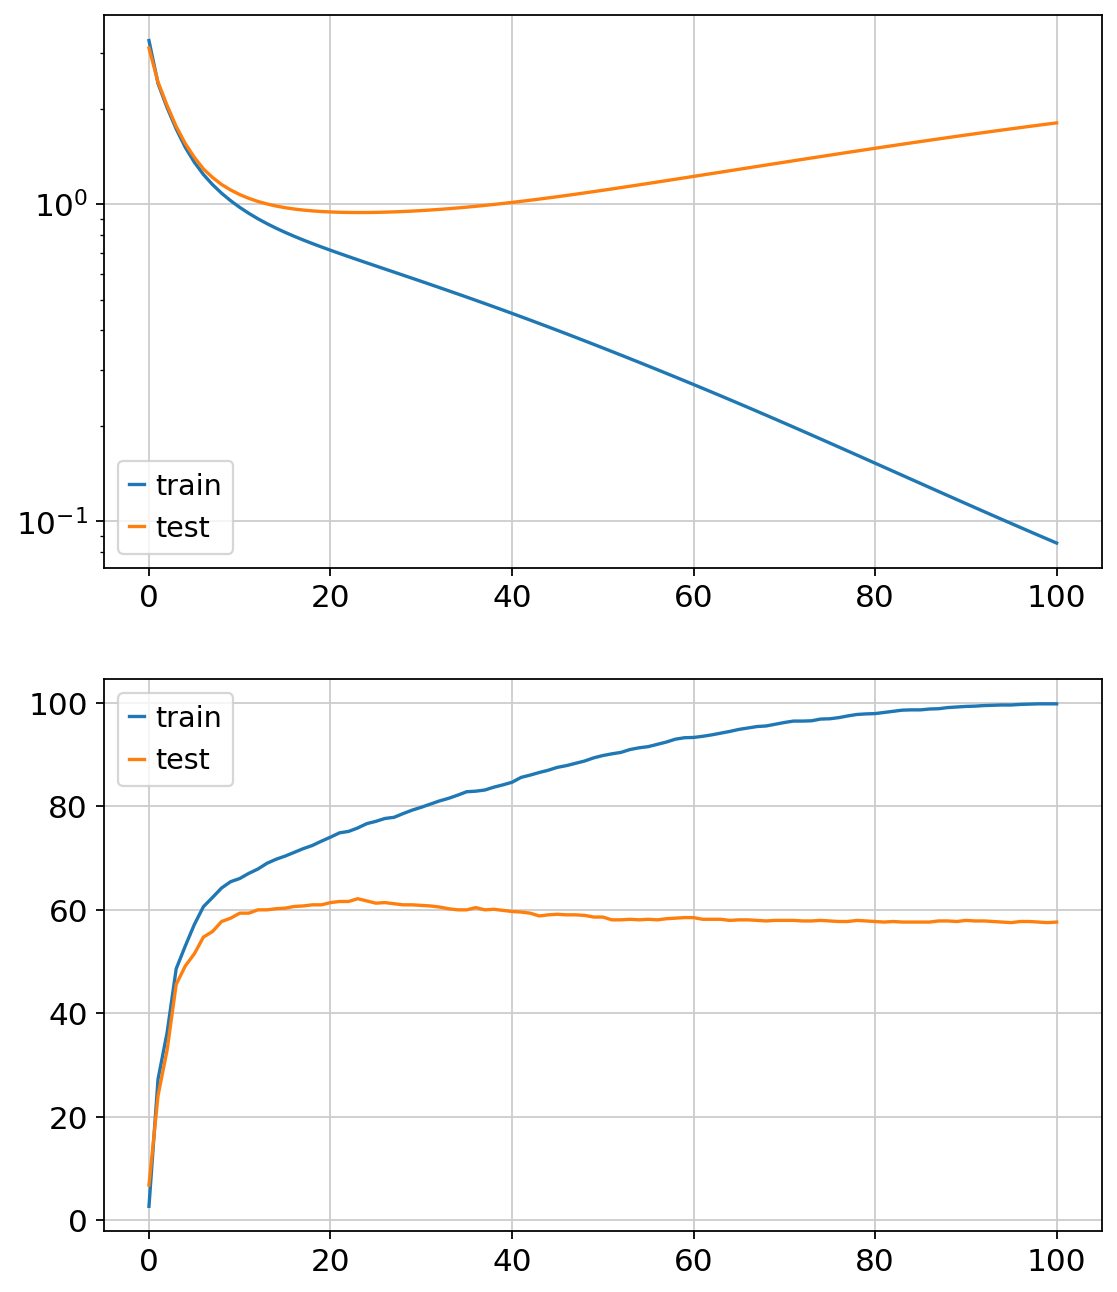

In [81]:
utils.seed(0) 

NUM_EPOCHS = 1001
LR = 0.001
n_train = 1800

edge_index = edge_index_pp 
#   accuracy: 57.74193572998047 (GCN) 
#   accuracy: 55.376346588134766 (graphSAGE)
#   accuracy: 49.462364196777344 (GAT)
#   accuracy: 54.40860366821289 (GINConv(MLP(input_dim, hidden_dim, hidden_dim), eps)) 
#   accuracy: 54.94623947143555 (ChebConv)
#   accuracy: 52.79569625854492 (EdgeConv)
#   accuracy: 53.01075744628906 (DynamicaEdgeConv)
# edge_index = edge_index_full
#   accuracy: 51.505374908447266 (GCN)
# edge_index = edge_index_empty 
#   accuracy: 52.473121643066406 (GCN)
# edge_index = edge_index_implied 
#   accuracy: 44.83871078491211 (GCN)
# edge_index = edge_index_knn

edge_index = edge_index.to(device)

input_dim = x.shape[1]
output_dim = data.num_categories(adata, target_col=target_col_categories)

num_layers =  1
hidden_dim = 64
args = [10]
kwargs = {}
model = gnn.GNN('GCN', input_dim, output_dim, *args, num_layers=num_layers, hidden_dim=hidden_dim, **kwargs).to(device)
# model = gnn.GNN_GIN(input_dim, output_dim, num_layers=num_layers, hidden_dim=hidden_dim, **kwargs).to(device)
# model = gnn.GNN_DGCNN(input_dim, output_dim, *args, num_layers=num_layers, hidden_dim=hidden_dim, **kwargs).to(device)
# model = gnn.GNN_Combo(input_dim, output_dim, hidden_dim=hidden_dim, batch_norm=False).to(device)
print('model params:', sum(p.numel() for p in model.parameters()))

obj = gnn.train(model, x, edge_index, y, n_train, lr=LR, num_epochs=NUM_EPOCHS)
gnn.eval(model, x, edge_index, y, n_train)
fig, ax = plt.subplots(2, figsize=(8, 10))
ax[0].plot(obj['train_losses'], label='train')
ax[0].plot(obj['test_losses'], label='test')
ax[0].set_yscale('log')
ax[0].legend()
ax[1].plot(obj['train_accs'], label='train')
ax[1].plot(obj['test_accs'], label='test')
ax[1].legend()
fig.show()

# GAT kwargs = {'heads': 16, 'concat': False}
# Cheb args = [10]
# GNN_GIN kwargs = {'eps': 0.1}
# DGCNN kwargs = {'dynamic': False}
# DGCNN kwargs = {'dynamic': True} args = [10]

# gin - REDUNDANT

In [15]:
import gin

accuracy: tensor(7.0406)


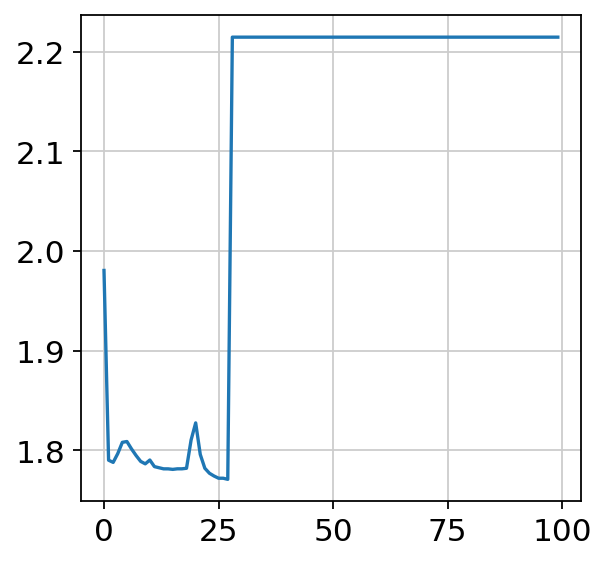

In [16]:
NUM_EPOCHS = 100
LR = 0.001 
n_train = 1800

x = torch.tensor(adata.X)
y = data.leiden2target_onehot(adata)
edge_index = data.connectivities2edge_index(adata)

input_dim = x.shape[1]
output_dim = data.num_categories(adata)

predmodel = mlp.SimpleMLP(hidden_dim, output_dim, hidden_dim)
model = gin.GIN(input_dim, hidden_dim, predmodel, 
    num_layers=4, eps=0.1, molecular=False)

losses = gin.train(model, x, y, edge_index, n_train, lr=LR, num_epochs=NUM_EPOCHS)
plt.plot(losses)
test_acc = gin.eval(model, x, y, edge_index, n_train)

# scgnn

In [17]:
import scgnn
from torch.utils.data import DataLoader

In [18]:
scdata = scgnn.scDataset(adata)
batch_size = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}

train_loader = DataLoader(
    scdata, batch_size=batch_size, shuffle=False, **kwargs)

In [19]:
model = scgnn.AE(input_dim)
for epoch in range(NUM_EPOCHS): 
    recon, original, z = scgnn.train(model, epoch, train_loader, log_interval=10)

Train Epoch: 0 [0/2638 (0%)]	Loss: 154.102783
Train Epoch: 0 [1000/2638 (37%)]	Loss: 152.614912
Train Epoch: 0 [2000/2638 (74%)]	Loss: 160.181143
====> Epoch: 0 Average loss: 158.2223
Train Epoch: 1 [0/2638 (0%)]	Loss: 150.976738
Train Epoch: 1 [1000/2638 (37%)]	Loss: 150.175049
Train Epoch: 1 [2000/2638 (74%)]	Loss: 159.067295
====> Epoch: 1 Average loss: 156.2206
Train Epoch: 2 [0/2638 (0%)]	Loss: 149.438984
Train Epoch: 2 [1000/2638 (37%)]	Loss: 148.777451
Train Epoch: 2 [2000/2638 (74%)]	Loss: 157.869443
====> Epoch: 2 Average loss: 155.0247
Train Epoch: 3 [0/2638 (0%)]	Loss: 146.038018
Train Epoch: 3 [1000/2638 (37%)]	Loss: 147.305908
Train Epoch: 3 [2000/2638 (74%)]	Loss: 156.636846
====> Epoch: 3 Average loss: 153.4593
Train Epoch: 4 [0/2638 (0%)]	Loss: 141.759004
Train Epoch: 4 [1000/2638 (37%)]	Loss: 145.366191
Train Epoch: 4 [2000/2638 (74%)]	Loss: 155.171660
====> Epoch: 4 Average loss: 151.7456
Train Epoch: 5 [0/2638 (0%)]	Loss: 138.226035
Train Epoch: 5 [1000/2638 (37%)]	L

In [20]:
# we have trained an unsupervised graph adjacency generator; generate an adjacency and see if downstream tasks perform 
prunetype = 'KNNgraphStatsSingleThread'
knn_distance = 'euclidean'
k = 10
useGAEembedding = False
useBothembedding = False

zOut = z.detach().cpu().numpy()

edgeList = scgnn.calculateKNNgraphDistanceMatrixStatsSingleThread(zOut, distanceType=knn_distance, k=k)

graphdict = scgnn.edgeList2edgeDict(edgeList, zOut.shape[0])
adj = scgnn.nx.adjacency_matrix(scgnn.nx.from_dict_of_lists(graphdict)).astype(np.float32)

Start pruning 0th cell, cost 8.678436279296875e-05s


/tmp/ipykernel_9131/1692572443.py:13: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = scgnn.nx.adjacency_matrix(scgnn.nx.from_dict_of_lists(graphdict)).astype(np.float32)


running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


(array([1241.,    0.,  372.,    0.,    0.,  645.,    0.,  365.,    0.,
          15.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

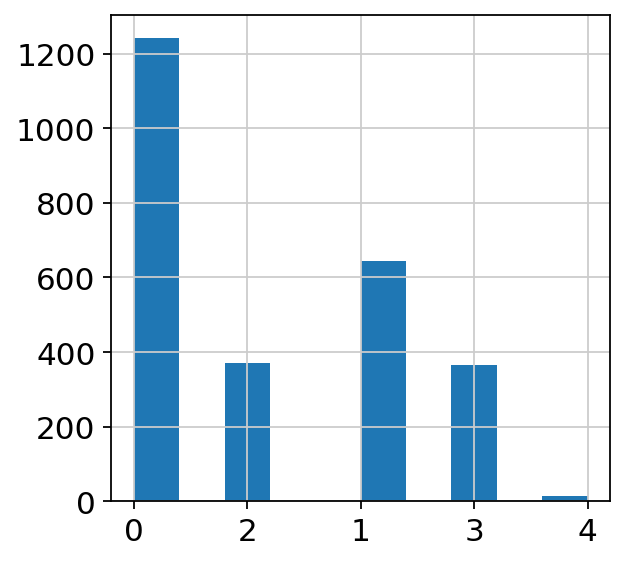

In [21]:
adata_mod = sc.tl.leiden(adata, adjacency=adj, copy=True)
plt.hist(adata_mod.obs.leiden.values)
# plt.hist(adata.obs.leiden.values)

In [22]:
n_train = 1800 

x_train, x_test, y_train, y_test = svm.split_data_cellclass(adata_mod, n_train)
clf = svm.svm_cellclass(x_train, y_train, x_test, y_test, kernel='linear')

SVM test accuracy: 94.39140811455847


In [23]:
model = scgnn.VAE(input_dim)
for epoch in range(NUM_EPOCHS): 
    recon, mu, logvar, z = scgnn.train(model, epoch, train_loader, log_interval=10)

Train Epoch: 0 [0/2638 (0%)]	Loss: 203.586816
Train Epoch: 0 [1000/2638 (37%)]	Loss: 167.579805
Train Epoch: 0 [2000/2638 (74%)]	Loss: 167.578066
====> Epoch: 0 Average loss: 175.4382


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
zOut = z.detach().cpu().numpy()
edgeList = scgnn.calculateKNNgraphDistanceMatrixStatsSingleThread(zOut, distanceType=knn_distance, k=k)
graphdict = scgnn.edgeList2edgeDict(edgeList, zOut.shape[0])
adj = scgnn.nx.adjacency_matrix(scgnn.nx.from_dict_of_lists(graphdict)).astype(np.float32)

n_train = 1800 
x_train, x_test, y_train, y_test = svm.split_data_cellclass(adata_mod, n_train)
clf = svm.svm_cellclass(x_train, y_train, x_test, y_test, kernel='linear')

Start pruning 0th cell, cost 4.744529724121094e-05s


/tmp/ipykernel_21805/1639978246.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = scgnn.nx.adjacency_matrix(scgnn.nx.from_dict_of_lists(graphdict)).astype(np.float32)


SVM test accuracy: 93.07875894988067


# hgt

In [ ]:
def adata_bipartite_adjacency(adata: sc.AnnData, edge_threshold=0.):
    n_cells, n_genes = adata.X.shape
    edges = (adata.X > edge_threshold) * (n_cells + np.arange(n_genes))
    edge_index_from, edge_index_to = [], []
    for i in range(n_cells):
        iedges = edges[i, :].nonzero()[0]
        edge_index_from += [i] * len(iedges)
        edge_index_to += iedges.tolist()
    edge_index = torch.tensor([edge_index_from + edge_index_to, edge_index_to + edge_index_from])
    return n_cells, n_genes, edge_index    


In [ ]:
n_cells, n_genes, badj = adata_bipartite_adjacency(adata, np.log(1 + 0.))
print(n_cells, n_genes)
badj.shape


2638 1838


torch.Size([2, 922424])

In [8]:
import HGT 
import torch.nn as nn 

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
adata_basic = data.preprocess_basic(data.get_pbmc3k())
sc.pp.neighbors(adata_basic, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata_basic)

labels = torch.tensor(adata_basic.obs.leiden.values.astype(int)).long()

... reading from cache file cache/..-scanpy-tutorials-data-filtered_gene_bc_matrices-hg19-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:09)
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


In [9]:
G, node_dict, edge_dict = HGT.get_heterograph_bipartite(adata_basic, device=device)
pprint(node_dict)
pprint(edge_dict)

{'cell': 0, 'gene': 1}
{'has-expression': 0, 'is-expressed': 1}


Training HGT with #param: 2506035
Epoch: 5 LR: 0.00005 Loss 2.5642, Train Acc 0.0189, Test Acc 0.0222 (Best 0.0222)
Epoch: 10 LR: 0.00007 Loss 2.3470, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 15 LR: 0.00011 Loss 2.1633, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 20 LR: 0.00015 Loss 2.1166, Train Acc 0.2350, Test Acc 0.1967 (Best 0.2044)
Epoch: 25 LR: 0.00022 Loss 2.0990, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 30 LR: 0.00028 Loss 2.0853, Train Acc 0.2311, Test Acc 0.2022 (Best 0.2044)
Epoch: 35 LR: 0.00036 Loss 2.0712, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 40 LR: 0.00044 Loss 2.0715, Train Acc 0.2328, Test Acc 0.2000 (Best 0.2044)
Epoch: 45 LR: 0.00053 Loss 2.0584, Train Acc 0.2394, Test Acc 0.2000 (Best 0.2044)
Epoch: 50 LR: 0.00061 Loss 2.0398, Train Acc 0.2467, Test Acc 0.2033 (Best 0.2044)
Epoch: 55 LR: 0.00069 Loss 2.0198, Train Acc 0.2667, Test Acc 0.1989 (Best 0.2044)
Epoch: 60 LR: 0.00077 Loss 1.9808, Train Acc 0.3194, T

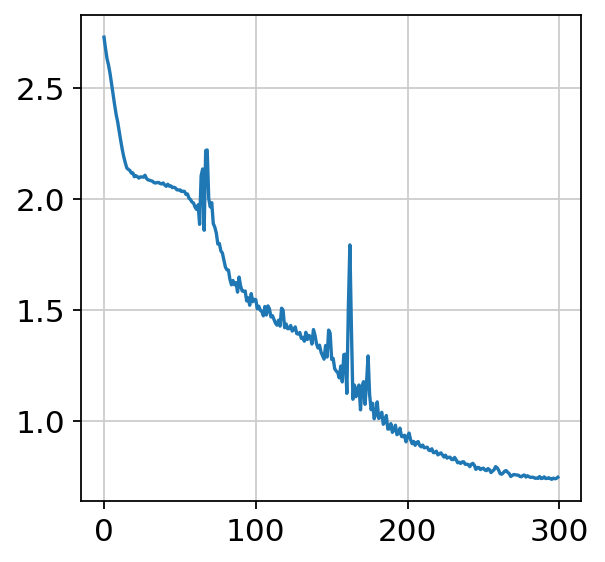

In [37]:
utils.seed(0) 

n_train = 1800 
NUM_EPOCHS = 300 
LR = 0.001 

n_inp = 256
n_hid = 256
n_layers = 2
n_heads = 4

#     Random initialize input feature
for ntype in G.ntypes:
    emb = nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), n_inp), requires_grad = False)
    nn.init.xavier_uniform_(emb)
    G.nodes[ntype].data['inp'] = emb.to(device)

model = HGT.HGT(G,
            node_dict, edge_dict,
            n_inp=n_inp,
            n_hid=n_hid,
            n_out=labels.max().item()+1,
            n_layers=n_layers,
            n_heads=n_heads,
            use_norm = True).to(device)
print('Training HGT with #param: %d' % (sum(p.numel() for p in model.parameters())))

model, losses, accs = HGT.train(model, G, labels, n_train, NUM_EPOCHS, lr=LR, use_scheduler=True)
plt.plot(losses)

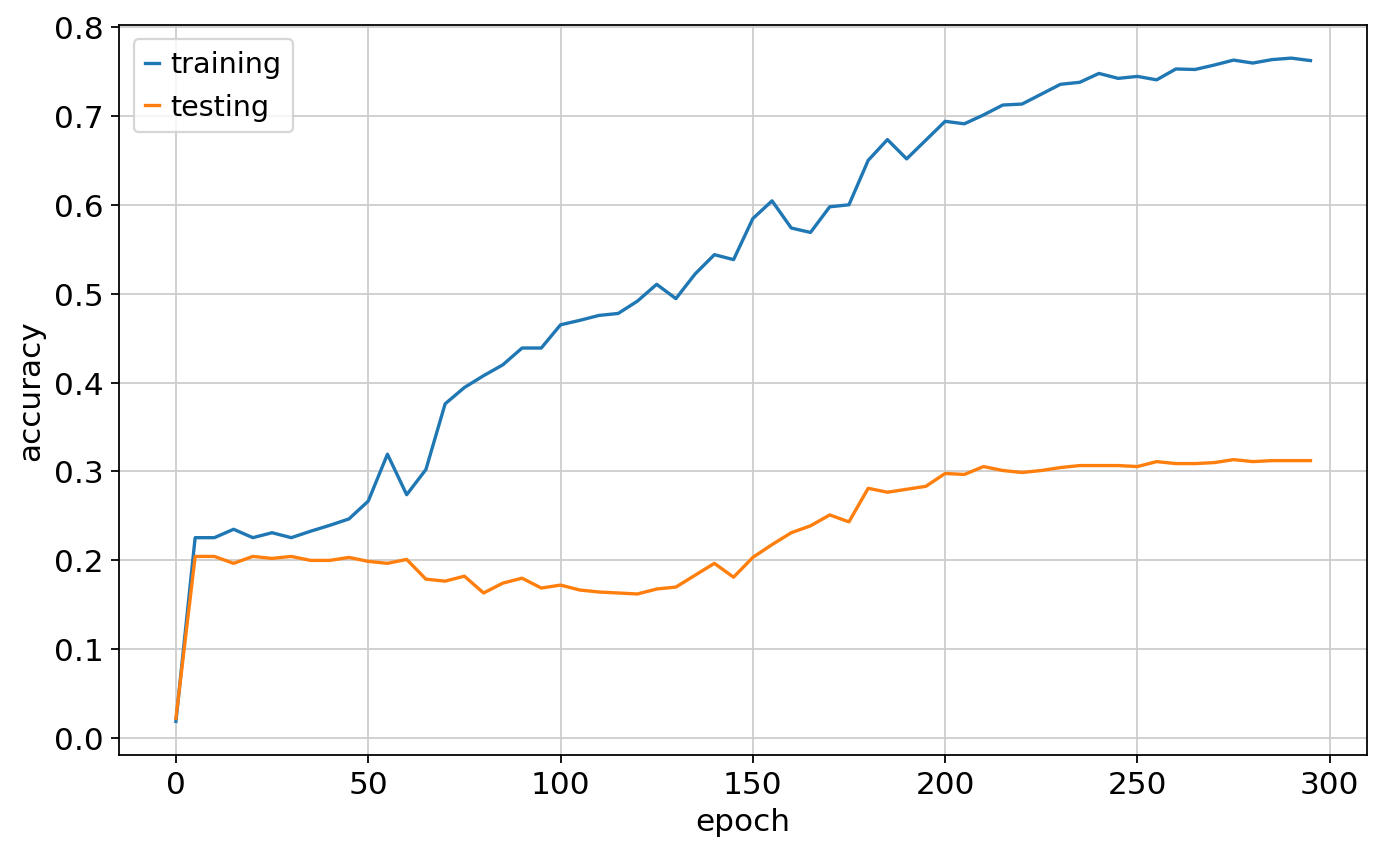

In [38]:
fig, ax = plt.subplots(figsize=(10, 6)) 
ax.plot(5 * np.arange(len(accs)), [i[0] for i in accs], label='training')
ax.plot(5 * np.arange(len(accs)), [i[1] for i in accs], label='testing')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()
fig.show()

In [43]:
model_path = '../models/'
torch.save(model.state_dict(), os.path.join(model_path, f'hgt_{n_inp}in_{n_hid}hid_{n_layers}lay_{n_heads}att.model'))

In [36]:
model.eval()
np.bincount(model(G, 'cell').argmax(1).cpu().numpy())

array([755, 621, 349, 326, 338,  96,  96, 100,  16,   2,   1])

In [37]:
pred   = model(G, 'cell').argmax(1).cpu()

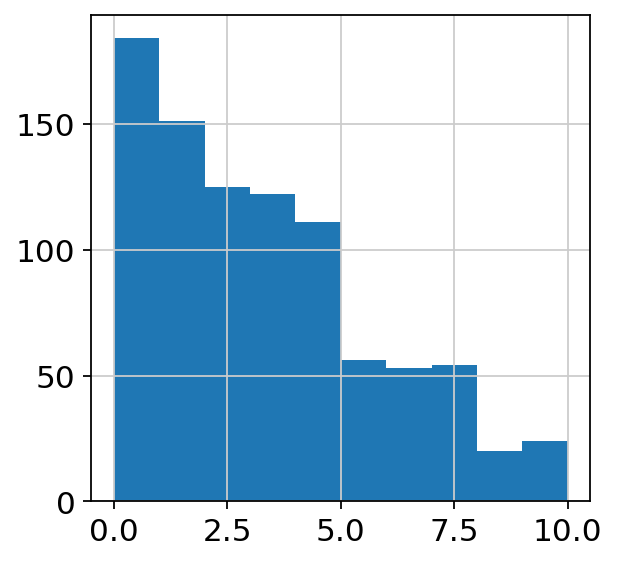

In [48]:
# plt.hist(pred[n_train:].tolist())
plt.hist(labels[n_train:].tolist())
plt.show()

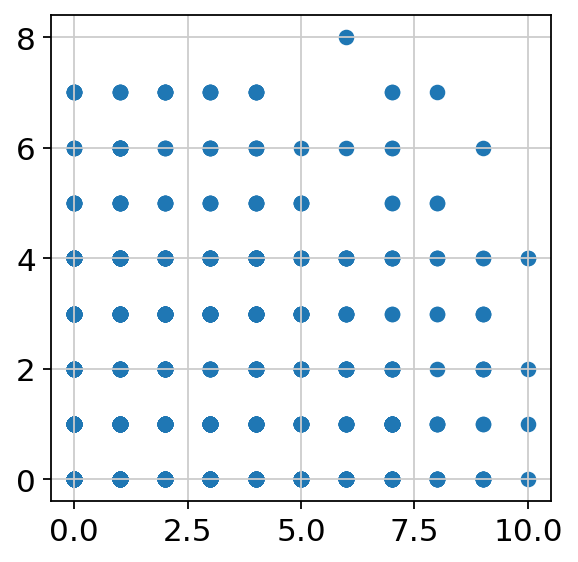

In [49]:
fig, ax = plt.subplots()
ax.scatter(labels[n_train:], pred[n_train:].float())
fig.show()

In [44]:
(pred == labels)[n_train:].float().mean()

tensor(0.1589)

In [63]:
n_inp = 256
n_hid = 256
n_layers = 2
n_heads = 4

#     Random initialize input feature
for ntype in G.ntypes:
    emb = nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), n_inp), requires_grad = False)
    nn.init.xavier_uniform_(emb)
    G.nodes[ntype].data['inp'] = emb.to(device)

model = HGT.HeteroRGCN(G,
                   in_size=n_inp,
                   hidden_size=n_hid,
                   out_size=labels.max().item()+1).to(device)
print('Training RGCN with #param: %d' % (sum(p.numel() for p in model.parameters())))
model, losses, best_test_acc = HGT.train(model, G, labels, n_train, NUM_EPOCHS)

Training RGCN with #param: 137238
Epoch: 5 LR: 0.00011 Loss 2.3877, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 10 LR: 0.00030 Loss 2.3851, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 15 LR: 0.00055 Loss 2.3793, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 20 LR: 0.00079 Loss 2.3690, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 25 LR: 0.00096 Loss 2.3530, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 30 LR: 0.00100 Loss 2.3309, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 35 LR: 0.00098 Loss 2.3039, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 40 LR: 0.00094 Loss 2.2742, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 45 LR: 0.00088 Loss 2.2443, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 50 LR: 0.00079 Loss 2.2170, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 55 LR: 0.00070 Loss 2.1939, Train Acc 0.2256, Test Acc 0.2044 (Best 0.2044)
Epoch: 60 LR: 0.00059 Loss 2.1757, Train Acc 0.2256, T

In [62]:
torch.save(model.state_dict(), os.path.join(model_path, f'rcgn_{n_inp}in_{n_hid}hid_{n_layers}lay_{n_heads}att.model'))

In [47]:
labels = torch.tensor(adata_paul15.obs.paul15_clusters_ind.values.astype(int)).long()

In [48]:
G, node_dict, edge_dict = HGT.get_heterograph_bipartite(adata_paul15, device=device)
pprint(node_dict)
pprint(edge_dict)

{'cell': 0, 'gene': 1}
{'has-expression': 0, 'is-expressed': 1}


Training HGT with #param: 1322279
Epoch: 5 LR: 0.00005 Loss 2.9754, Train Acc 0.0933, Test Acc 0.0753 (Best 0.0753)
Epoch: 10 LR: 0.00007 Loss 2.8855, Train Acc 0.0961, Test Acc 0.0785 (Best 0.0785)
Epoch: 15 LR: 0.00011 Loss 2.8062, Train Acc 0.1428, Test Acc 0.1183 (Best 0.1183)
Epoch: 20 LR: 0.00015 Loss 2.7192, Train Acc 0.1444, Test Acc 0.1215 (Best 0.1215)
Epoch: 25 LR: 0.00022 Loss 2.6777, Train Acc 0.1450, Test Acc 0.1215 (Best 0.1215)
Epoch: 30 LR: 0.00028 Loss 2.6748, Train Acc 0.1467, Test Acc 0.1215 (Best 0.1215)
Epoch: 35 LR: 0.00036 Loss 2.6593, Train Acc 0.1450, Test Acc 0.1215 (Best 0.1215)
Epoch: 40 LR: 0.00044 Loss 2.6483, Train Acc 0.1522, Test Acc 0.1247 (Best 0.1247)
Epoch: 45 LR: 0.00053 Loss 2.6247, Train Acc 0.1544, Test Acc 0.1247 (Best 0.1247)
Epoch: 50 LR: 0.00061 Loss 2.6063, Train Acc 0.1622, Test Acc 0.1258 (Best 0.1258)
Epoch: 55 LR: 0.00069 Loss 2.5874, Train Acc 0.2089, Test Acc 0.1204 (Best 0.1258)
Epoch: 60 LR: 0.00077 Loss 2.5511, Train Acc 0.2317, T

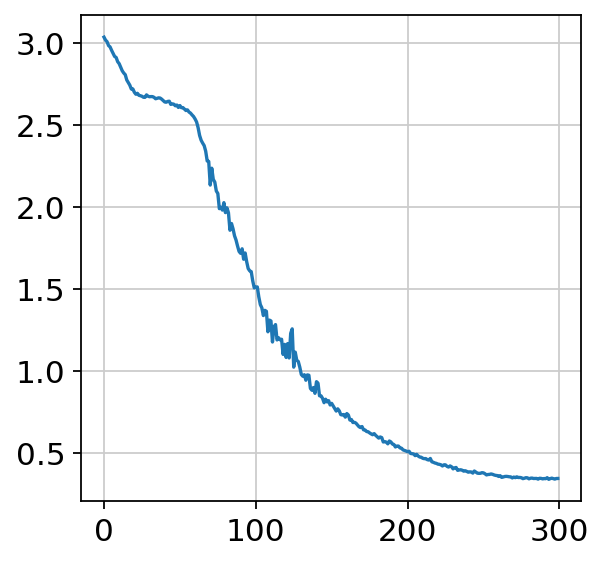

In [49]:
utils.seed(0) 

n_train = 1800 
NUM_EPOCHS = 300 
LR = 0.001 

n_inp = 256
n_hid = 256
n_layers = 2
n_heads = 4

#     Random initialize input feature
for ntype in G.ntypes:
    emb = nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), n_inp), requires_grad = False)
    nn.init.xavier_uniform_(emb)
    G.nodes[ntype].data['inp'] = emb.to(device)

model = HGT.HGT(G,
            node_dict, edge_dict,
            n_inp=n_inp,
            n_hid=n_hid,
            n_out=labels.max().item()+1,
            n_layers=n_layers,
            n_heads=n_heads,
            use_norm = True).to(device)
print('Training HGT with #param: %d' % (sum(p.numel() for p in model.parameters())))

model, losses, accs = HGT.train(model, G, labels, n_train, NUM_EPOCHS, lr=LR, use_scheduler=True)
plt.plot(losses)

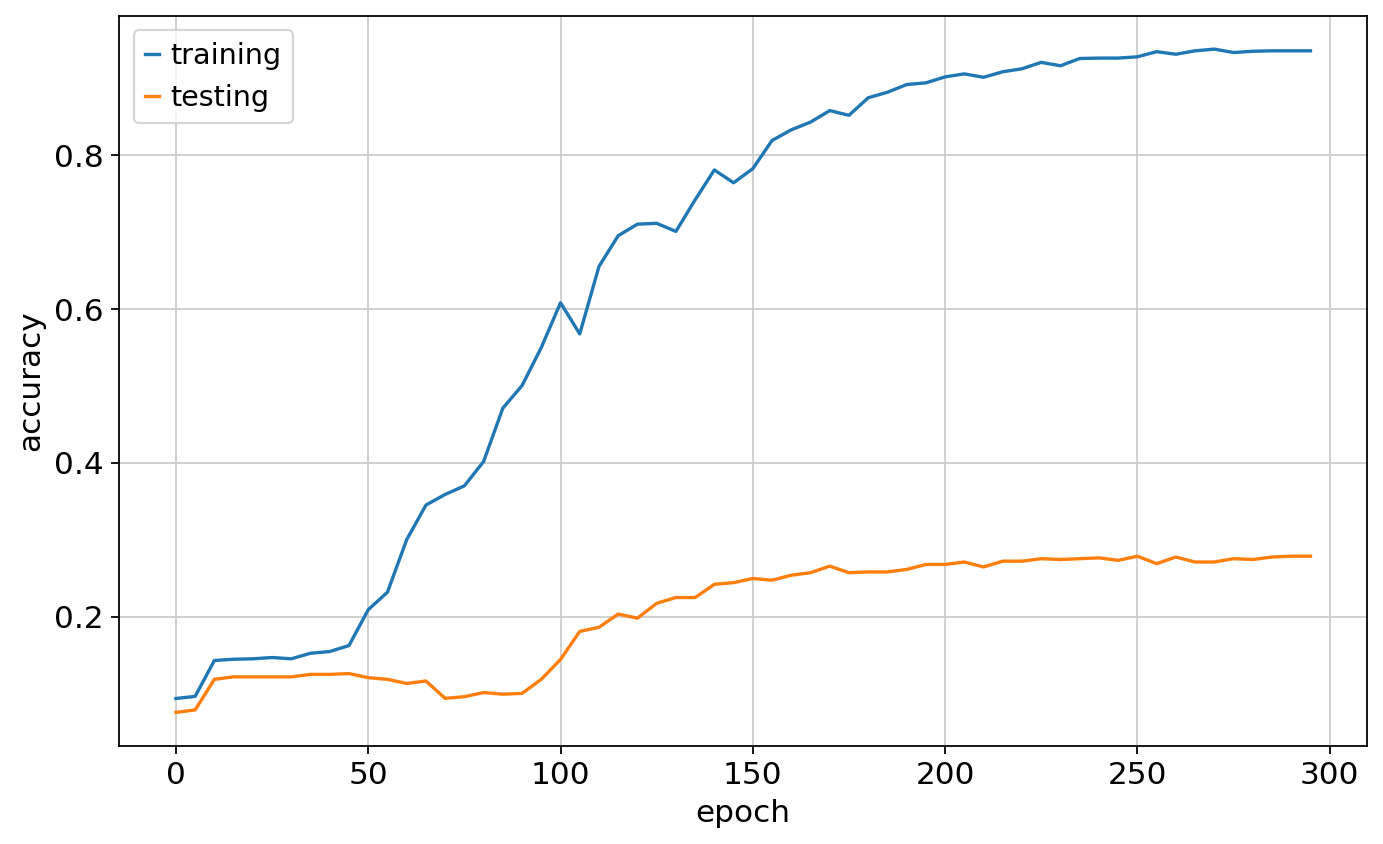

In [50]:
fig, ax = plt.subplots(figsize=(10, 6)) 
ax.plot(5 * np.arange(len(accs)), [i[0] for i in accs], label='training')
ax.plot(5 * np.arange(len(accs)), [i[1] for i in accs], label='testing')
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend()
fig.show()

# heterogeneous bipartite graph 
- HGT, HAN, GRAPE

In [ ]:
import GRAPE.uci.uci_data as uci_data 

In [ ]:
def create_cell_graph():
    pass 

def create_cell_gene_graph(adata: sc.AnnData): 
    pass 

def create_cell_gene_hetgraph(adata: sc.AnnData, emb_dim): 
    data = create_cell_gene_graph(adata)
    
    nrow, ncol = adata.X.shape
    data_het = data.to_heterogeneous(
        node_type=torch.tensor([0]*nrow + [1]*ncol), node_type_names=['cell', 'gene'], 
        edge_type=torch.tensor([0]*int(data.num_edges/2) + [1]*int(data.num_edges/2)), 
        edge_type_names=[('cell', 'has-expression', 'gene'), ('gene', 'is-expressed', 'cell')]
    )
    data_het.get_node_store('cell')['x'] = data_het.get_node_store('cell')['x'].repeat(1, emb_dim)
    return data_het


In [ ]:
split_sample = 0. 
node_mode = 2 
train_edge = 0.7 
split_by = 'y'
train_y = 0.7 
seed = 0

data_1 = uci_data.load_data(adata, target_col=target_col, node_mode=node_mode, 
        train_edge=train_edge, split_sample=split_sample, split_by=split_by, train_y=train_y, seed=seed,
        one_hot=True)
nrow, ncol = adata.X.shape 

data_het = data_1.to_heterogeneous(
        node_type=torch.tensor([0]*nrow + [1]*ncol), node_type_names=['cell', 'gene'], 
        edge_type=torch.tensor([0]*int(data.num_edges/2) + [1]*int(data.num_edges/2)), 
        edge_type_names=[('cell', 'has-expression', 'gene'), ('gene', 'is-expressed', 'cell')])

emb_dim = 16 
data_het.get_node_store('cell')['x'] = data_het.get_node_store('cell')['x'].repeat(1, emb_dim)
